In [30]:
class Ciao:
    tipo = 'ciao'
    print(tipo)

ciao


In [32]:
Ciao().tipo

'ciao'

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [8]:
QuantileRegression

darts.utils.likelihood_models.QuantileRegression

In [2]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [3]:
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=[0.1,0.5,0.9]
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [4]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)


Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

In [5]:
pred_series = my_model.predict(n=2)

Predicting: 0it [00:00, ?it/s]

In [6]:
pred_series.pd_dataframe()

component,#Passengers
Month,
1958-01-01,0.656481
1958-02-01,0.707345


In [7]:
pred_series = my_model.predict(n=3)
pred_series.pd_dataframe()

Predicting: 0it [00:00, ?it/s]

component,#Passengers
Month,
1958-01-01,0.650202
1958-02-01,0.714607
1958-03-01,0.777737


In [8]:
import random
def random_walk(n):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        probs[i+1]= prob
    return tot, probs
N = 20000
random.seed(6)
x, p = random_walk(N)
data = pd.DataFrame({'y':x,'p':p,'time':pd.to_datetime(100000*np.array(list(range(N))))})
series = TimeSeries.from_dataframe(data, "time", "y")


In [9]:
pseries = TimeSeries.from_times_and_values(
        times=series.time_index,
        values=data.p.values,
       
    )

In [10]:
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=[0.1,0.5,0.9]
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)
my_model.fit(train_transformed, future_covariates=pseries, verbose=True)


ValueError: Missing covariates; could not find past covariates in index value range: 1955-01-01 00:00:00 - 1956-12-01 00:00:00.

In [5]:
import numpy as np
pred = np.load('/home/agobbi/Projects/PatchTST/PatchTST_supervised/results/64__PatchTST_custom_ftM_sl64_ll48_pl64_dm128_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
real = np.load('/home/agobbi/Projects/PatchTST/PatchTST_supervised/results/64__PatchTST_custom_ftM_sl64_ll48_pl64_dm128_nh16_el3_dl1_df256_fc1_ebtimeF_dtTrue_Exp_0/true.npy')

In [6]:
pred.shape

(10368, 64, 21)

In [7]:
real.shape

(10368, 64, 21)

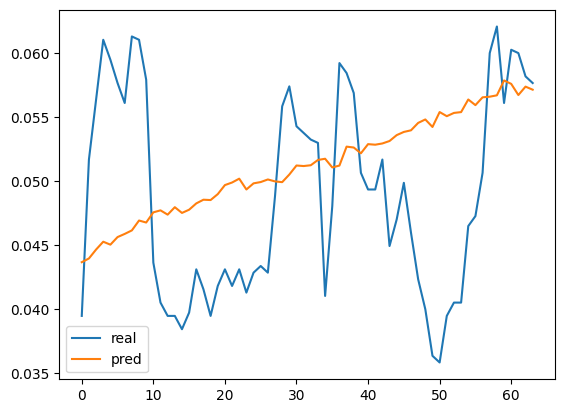

In [26]:
import matplotlib.pyplot as plt
plt.plot(real[-1,:,-1],label='real')
plt.plot(pred[-1,:,-1],label='pred')
plt.legend()


In [36]:
m =(4.88+2.24)/(0.25+0.05)
q = 4.88-m*0.25
err = np.abs(m*real[:,:,-1]-m*pred[:,:,-1]).mean()
err

0.5219727

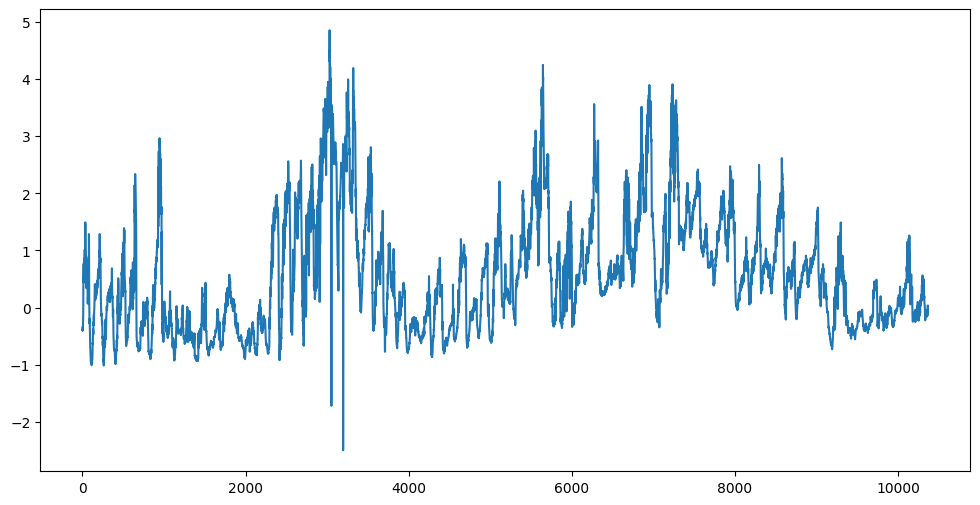

In [37]:
plt.figure(figsize=(12,6))
plt.plot(m*real[:,0,-1]+q)

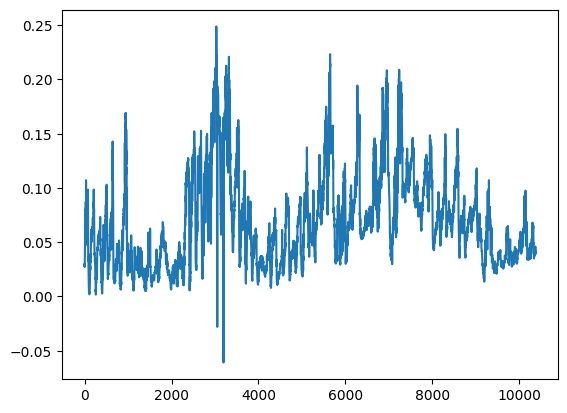

In [33]:
plt.plot(real[:,0,-1])

23.733333333333334